# Bubble data

I have the idea of creating a class for the bubble data. The data we use are effectively np.ndarray, but it is convenient to have a few methods specific to our simulation, such as `get_center`, `get_edge`, etc. 

Another idea is it might be nice to have an interface to interact with the .h5 simulation data, to speed up visualization.

## 0 Packages

In [14]:
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
import pyvista as pv
pv.set_jupyter_backend("trame")
import yaml
import numpy as np
import time

## 1 Read data

In [15]:
folder = Path("~/Documents/BC_simulation/test").expanduser().resolve()
with h5py.File(folder / "results" / "data.h5", "r") as f:
    t = f["t"][:]
    x = f["x"][:]
    h = f["h"][:]

In [16]:
with open(folder / "params.yaml") as f:
    params = yaml.safe_load(f)

In [17]:
mesh = np.load(folder / "mesh.npy")

## 2 Plot trajectory using `matplotlib`

(np.float64(-0.001007066046815768),
 np.float64(0.021148386983131127),
 np.float64(0.000283461556965733),
 np.float64(0.0017787170921948411))

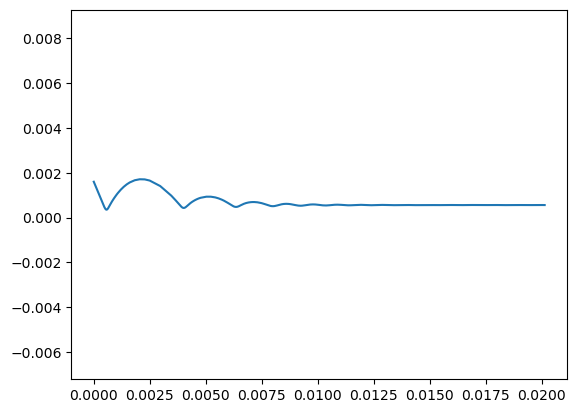

In [18]:
plt.plot(x[:, 0], x[:, 1])
plt.axis("equal")

## 3 Plot trajectory using `pyvista`

In [ ]:
traj = pv.PolyData(x[::])
theta = params["theta"] / 180 * np.pi
up = np.array([np.sin(theta), -np.cos(theta), 0])
cmap = plt.get_cmap("tab10")
pl = pv.Plotter()

pl.add_mesh(traj, color=cmap(0))

pl.camera_position = [(0, 0, -20),
                      (0, 0, 0),
                      up]
pl.reset_camera()
pl.camera.zoom(.7)
# pl.camera.parallel_projection = True  # Toggle off perspective

pl.show_axes()
pl.show()

Widget(value='<iframe src="http://localhost:54338/index.html?ui=P_0x17e056cf0_0&reconnect=auto" class="pyvista…

wslink is not expecting text message:
> Cannot write to closing transport
wslink is not expecting text message:
> Cannot write to closing transport
wslink is not expecting text message:
> Cannot write to closing transport


## 4 Plot mesh shape using `pyvista`

In [49]:
center = (
        (x[:, 0].min() + x[:, 0].max()) / 2,
        (x[:, 1].min() + x[:, 1].max()) / 2
)
                
points = np.column_stack([mesh[:, 0], h[0], mesh[:, 2]])
surf = pv.PolyData(points).delaunay_2d()
theta = params["theta"] / 180 * np.pi
up = np.array([np.sin(theta), -np.cos(theta), 0])
pl = pv.Plotter()
pl.camera_position = [(center[0], center[1], -0.05),
                      (center[0], center[1], 0),
                      up]
pl.add_mesh(surf)
pl.show_axes()
pl.enable_anti_aliasing()
pl.show()

Widget(value='<iframe src="http://localhost:64185/index.html?ui=P_0x1581ef320_18&reconnect=auto" class="pyvist…

## 5 Simplify the visualization code

Currently, the visualization code contains several things that makes the code long and hard to read. Ideally, we can simplify the code to 

```
# pseudo code
add_environment
add_actor1
add_actor2
add_camera
make_movie
```

The actors here should contain the time series data like locations and shape, and the make movie method should interpolate these time series data to the desired time mesh and make movie.

In this section, we implement the classes and methods that attempt to achieve these simplifications.

In [2]:
from pyvistaqt import BackgroundPlotter
import pyvista as pv
from scipy.interpolate import interp1d
import numpy as np
import time
from PyQt5.QtWidgets import QApplication, QMainWindow

In [3]:
class Scene(BackgroundPlotter):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.t = np.array([0])
        self.actor_list = []

    def add(self, mesh, data):
        """Add mesh as actor to scene. 

        Parameters
        ----------
        mesh : pyvista.DataSet
            The mesh to be added.
        data : dict
            Trajectory data, must contain 't' and 'x'.
        """
        t, x = self._read_data(data)
        self.t = t
        actor = self.add_mesh(mesh)
        actor_data = (actor, data)
        self.actor_list.append(actor_data)
        self.interp_actor_list = self.actor_list.copy()

    def _read_data(self, data):
        """Validate the data: (i) contains 'x' and 't', (ii) 'x' has shape (N, 3), (iii) t.shape[0] = x.shape[0]."""
        if not all(k in data for k in ["t", "x"]):
            raise ValueError("Input data dictionary must contain 't' and 'x'.")
        
        t = np.asarray(data["t"])
        x = np.asarray(data["x"])

        # ensure position data shape
        if x.ndim != 2 or x.shape[1] != 3:
            raise ValueError("The position data shape must be (N, 3).")
        
        # ensure t and x are the same length
        assert x.shape[0] == t.shape[0]

        return t, x

    def _interp(self, data):
        """Generate interpolation constructor based on input data.
        
        Parameters
        ----------
        data : dict
            Trajectory data, must contain 't' and 'x'.
        
        Returns
        -------
        interp_x : scipy.interpolate.interp1d
        """
        # validate input data structure
        t, x = self._read_data(data)
    
        # construct the interpolator
        interp_x = interp1d(t, x, axis=0, fill_value="extrapolate")

        return interp_x

    def set_time(self, t):
        """Set the time points to prepare the video. Update the 'data_interp' field with interpolated data.
        
        Parameters
        ----------
        t : array_like[float]
            Time sequence to evaluate the object positions.
        """
        self.t = t
        self.interp_actor_list = []
        for actor, data in self.actor_list:
            x = self._interp(data)
            self.interp_actor_list.append((actor, {"t": t, "x": x}))
    
    def run(self):
        for i in range(len(self.t)):
            new_pos = self.actor_list[0][1]["x"][i]
            self.actor_list[0][0].SetPosition(new_pos)
            self.render()
            QApplication.processEvents() # let Qt process UI events
            time.sleep(0.1)

In [8]:
scene = Scene(window_size=(800, 500))
N = 50
data = {
    "t" : np.linspace(0, 1, N),
    "x" : np.column_stack([np.linspace(0, 10, N), np.zeros(N), np.zeros(N)])
}
mesh = pv.Sphere()
scene.add(mesh, data)

In [41]:
scene.run()

In [12]:
app = QApplication([])
window = QMainWindow()
window.show()
app.exec_()

KeyboardInterrupt: 

In [ ]:
plotter = BackgroundPlotter(show=False)
plotter.setWindowFlags(Qt.SubWindow)
plotter.setParent(window)
plotter.setGeometry(10, 10, 400, 400)
plotter.show()

In [ ]:
pl = Scene(app=app)

In [37]:
from PyQt5.QtWidgets import QApplication

for i in range(20):
    scene.actor_list[0][0].SetPosition((i*0.1, 0 , 0))
    scene.render()
    QApplication.processEvents()
    time.sleep(0.05)

In [31]:
scene.reset_camera()

In [64]:
class MovingActor:
    def __init__(self, mesh, data):
        """This class implements actor of which the positino can be set according to input data. 
        data is the time series that describes the motion of the actor. Other key words, except the radius and the center, are passed on to the superclass.
        
        Parameters
        ----------
        mesh : pyvista.DataSet
            The PyVista mesh (e.g., pv.Sphere(), pv.Cube()) that this actor will represent. This mesh will be used as the visual representation of the actor.
        data : dict
            the time series that describes the motion of the actor. Other key words, except the center, are passed on to the superclass.actor motion data, must contain "t" and "x".
        **kwargs : 
            Additional keyword arguments passed directly to the pv.Actor constructor. These can include properties like `color`, `opacity`, `show_edges`, etc.
        """

        # validate input data structure
        if not all(k in data for k in ["t", "x"]):
            raise ValueError("Input data dictionary must contain 't' and 'x'.")
        
        t = np.asarray(data["t"])
        x = np.asarray(data["x"])

        # ensure position data shape
        if x.ndim != 2 or x.shape[1] != 3:
            raise ValueError("The position data shape must be (N, 3).")

        # initialize the actor using the super class __init__() method

        mapper = pv.DataSetMapper(mesh)
        self.actor = pv.Actor(mapper)

        # construct the interpolator
        self.interp_x = interp1d(t, x, axis=0, fill_value="extrapolate")

        # set the initial position
        initial_pos = self.interp_x(t[0])

        self.actor.SetPosition(initial_pos)

    def set_time(self, t):
        """Set the position of actor according to the input data. 
        
        Parameters
        ----------
        t : float
            The current time value for which to set the actor's position.
        """
        x = self.interp_x(t)
        self.actor.setPosition(x)

In [55]:
f(3).shape

(3,)

In [66]:
scene = Scene()
N = 50
data = {
    "t" : np.linspace(0, 1, N),
    "x" : np.random.rand(N, 3)
}
actor = MovingActor(pv.Sphere(), data).actor
scene.add_actor(actor)

(Actor (0x304cbd9c0)
   Center:                     (0.5641372013586219, 0.912086958572909, 0.8182945533151926)
   Pickable:                   True
   Position:                   (0.5641372013586218, 0.9120869585729089, 0.8182945533151927)
   Scale:                      (1.0, 1.0, 1.0)
   Visible:                    True
   X Bounds                    6.487E-02, 1.063E+00
   Y Bounds                    4.156E-01, 1.409E+00
   Z Bounds                    3.183E-01, 1.318E+00
   User matrix:                Identity
   Has mapper:                 True
 
 Property (0x304c7ab00)
   Ambient:                     0.0
   Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Anisotropy:                  0.0
   Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Culling:                     "none"
   Diffuse:                     1.0
   Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Edge color:

In [68]:
scene.actors

{'Actor(Addr=0x3531d2da0)': Actor (0x304cbd9c0)
   Center:                     (0.5641372013586219, 0.912086958572909, 0.8182945533151926)
   Pickable:                   True
   Position:                   (0.5641372013586218, 0.9120869585729089, 0.8182945533151927)
   Scale:                      (1.0, 1.0, 1.0)
   Visible:                    True
   X Bounds                    6.487E-02, 1.063E+00
   Y Bounds                    4.156E-01, 1.409E+00
   Z Bounds                    3.183E-01, 1.318E+00
   User matrix:                Identity
   Has mapper:                 True
 
 Property (0x304c7ab00)
   Ambient:                     0.0
   Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Anisotropy:                  0.0
   Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
   Culling:                     "none"
   Diffuse:                     1.0
   Diffuse color:               Color(name='lightblue', hex='#add8e6ff', 

In [67]:
scene.set_time(0.5)
scene.update()

AttributeError: 'Actor' object has no attribute 'set_time'

In [22]:
keys = pl.actors.keys()

In [31]:
attrs = pl.actors[list(keys)[0]].__dir__()

In [32]:
for attr in attrs:
    if "setpos" in attr.lower():
        print(attr)

SetPosition


In [41]:
pl.actors[list(keys)[0]].SetPosition((0,0,0))

## 6 Force

In [18]:
from pathlib import Path
import h5py
import matplotlib.pyplot as plt

In [29]:
folder = Path("~/Documents/.bcsim_test").expanduser().resolve()
data_file = folder / "results" / "data.h5"
data = {}
with h5py.File(data_file, "r") as f:
    for key in f.keys():
        data[key] = f[key][:]

(0.01, 0.025)

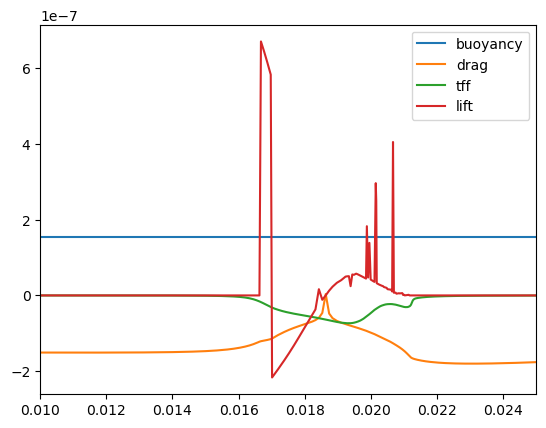

In [30]:
for key in ["buoyancy", "drag", "tff", "lift"]:
    plt.plot(data["t"], data[key][:, 0], label=key)
plt.legend()
plt.xlim([0.01, 0.025])